<a href="https://colab.research.google.com/github/ray021207/Comparative-Study-of-Approaches-for-Injury-Risk-Prediction-in-Athletes/blob/main/1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from google.colab import files
from scipy import stats

In [51]:
# df = pd.read_csv("mhealth_full.csv")

# STEP 2: Create Proxy Risk Label
# df["acc_chest_total"] = np.sqrt(df["acc_chest_x"]**2 + df["acc_chest_y"]**2 + df["acc_chest_z"]**2)
# high_impact = df["acc_chest_total"] > 3.5
# fatigue = ((df["activity_label"].isin([0, 1])) & ((df["ecg_1"].abs() > 0.5) | (df["ecg_2"].abs() > 0.5)))
# df["is_dynamic"] = df["activity_label"].isin([4, 5])
# df["repetitive_stress"] = df["is_dynamic"].rolling(window=150, min_periods=1).sum() > 100
# gyro_instability = df[["gyro_wrist_x", "gyro_wrist_y", "gyro_wrist_z"]].std(axis=1) > 2.5
# df["risk_label"] = (high_impact | fatigue | df["repetitive_stress"] | gyro_instability).astype(int)

# # STEP 3: SUBJECT-WISE SPLIT
# val_subjects = df["subject"].unique()[:2]
# val_df = df[df["subject"].isin(val_subjects)].copy()
# train_df = df[~df["subject"].isin(val_subjects)].copy()

# feature_cols = [col for col in df.columns if col not in ['activity_label', 'subject', 'risk_label']]
# scaler = StandardScaler()
# train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
# val_df[feature_cols] = scaler.transform(val_df[feature_cols])

# Function to Create Windows
# def create_windows(df, feature_cols, label_col, window_size=100, stride=50):
#     X_windows, y_windows = [], []
#     for i in range(0, len(df) - window_size, stride):
#         window = df.iloc[i:i+window_size]
#         X = window[feature_cols].values
#         y = window[label_col].mode()[0]
#         X_windows.append(X)
#         y_windows.append(y)
#     return np.stack(X_windows), np.array(y_windows)

# X_train, y_train = create_windows(train_df, feature_cols, 'risk_label')
# X_val, y_val = create_windows(val_df, feature_cols, 'risk_label')
train_X = pd.read_csv("mhealth_raw_data.csv")
test_X = pd.read_csv("test.csv")
train_X.shape,test_X.shape

#3. RISK LABEL MAPPING (Corrected and Improved)
activity_to_risk = {
    0: 0, # Nothing
    1: 0, # Standing still
    2: 0, # Sitting and relaxing
    3: 0, # Lying down
    4: 1, # Walking
    5: 1, # Climbing stairs
    6: 1, # Waist bends forward
    7: 0, # Frontal elevation of arms
    8: 1, # Knees bending (crouching)
    9: 1, # Cycling
    10:1, # Jogging
    11:1, # Running
    12:1  # Jumping front & back
}

y_train = train_X['Activity'].map(activity_to_risk)
y_test = test_X['Activity'].map(activity_to_risk)

# Then drop 'activity' and 'subject' columns from features
X_train = train_X.drop(columns=['Activity', 'subject'])
X_test = test_X.drop(columns=['Activity', 'subject'])

# CREATE WINDOWED DATASETS
def create_dataset(X, y, time_steps=100, step=50):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i:(i + time_steps)]
        Xs.append(x)
        ys.append(stats.mode(labels, keepdims=True)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

X_train_seq, y_train_seq = create_dataset(X_train, y_train, time_steps=100, step=50)
X_test_seq, y_test_seq = create_dataset(X_test, y_test, time_steps=100, step=50)

print(X_train_seq.shape, y_train_seq.shape)
print(X_test_seq.shape, y_test_seq.shape)

# # Downsample to Balance the Classes
# risky_idxs = np.where(y_train == 1)[0]
# safe_idxs = np.where(y_train == 0)[0]
# min_len = min(len(risky_idxs), len(safe_idxs))
# sel_risk = resample(risky_idxs, n_samples=min_len, replace=False, random_state=42)
# sel_safe = resample(safe_idxs, n_samples=min_len, replace=False, random_state=42)
# idxs = np.concatenate([sel_risk, sel_safe])
# X_train, y_train = X_train[idxs], y_train[idxs]

# # Convert to PyTorch Tensors
# X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)
# y_train = torch.tensor(y_train, dtype=torch.long)
# X_val = torch.tensor(X_val, dtype=torch.float32).permute(0, 2, 1)
# y_val = torch.tensor(y_val, dtype=torch.long)

# train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
# val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)



(4923, 100, 12) (4923, 1)
(1285, 100, 12) (1285, 1)


In [53]:

# Define 1D CNN Model
class InjuryRisk1DCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(InjuryRisk1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(self.fc1(x))
        return self.fc2(x)

# Setup Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InjuryRisk1DCNN(input_channels=X_train.shape[1], num_classes=2).to(device)

# Use Class Weights in Loss
class_counts = np.bincount(y_train.to_numpy()) # Changed from .numpy() to .to_numpy()
class_weights = torch.tensor([class_counts[1], class_counts[0]]).float().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)



In [54]:
df.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,-0.018998,-0.082694,0.335263,0.822289,-0.456693,-0.683956,-0.246205,-0.344301,0.885793,0.776220,-0.851454,0.660450,0,subject9
1,-0.088755,-0.062304,-0.052911,1.206683,-0.096740,0.834662,0.131119,-1.053013,-0.355188,-0.093750,-0.030552,1.279407,0,subject9
2,-0.164168,-0.159863,0.218093,-1.339886,-0.491787,0.891293,0.184817,-0.350493,-0.322810,-1.046067,-0.480360,-1.142975,0,subject9
3,0.431684,-0.427502,-0.542847,-1.700259,-0.193296,-1.119363,0.045475,-0.636251,-0.694289,0.228453,-1.110010,-1.584539,0,subject9
4,0.060682,-0.130611,0.228941,1.370856,-0.092341,0.533760,0.378342,-1.244299,-0.164203,0.235614,-0.105523,1.296066,0,subject9


In [56]:
# Convert to PyTorch Tensors
# Reshape to [batch_size, channels, sequence_length] for 1D CNN
X_train = torch.tensor(X_train_seq, dtype=torch.float32).permute(0, 2, 1)  # Change here
y_train = torch.tensor(y_train_seq, dtype=torch.long).squeeze(1)  # Change here
X_val = torch.tensor(X_test_seq, dtype=torch.float32).permute(0, 2, 1)  # Change here
y_val = torch.tensor(y_test_seq, dtype=torch.long).squeeze(1)  # Change here

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

# ... (rest of the code)


In [57]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(preds, dim=1)
        correct_train += (predicted == yb).sum().item()
        total_train += yb.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
            predicted = torch.argmax(preds, dim=1)
            correct_val += (predicted == yb).sum().item()
            total_val += yb.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1:02d} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f} | Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")


Epoch 01 - Train Loss: 0.099595, Val Loss: 0.153297 | Train Acc: 0.9636, Val Acc: 0.9525
Epoch 02 - Train Loss: 0.037684, Val Loss: 0.094878 | Train Acc: 0.9886, Val Acc: 0.9525
Epoch 03 - Train Loss: 0.018281, Val Loss: 0.081801 | Train Acc: 0.9967, Val Acc: 0.9556
Epoch 04 - Train Loss: 0.009712, Val Loss: 0.027576 | Train Acc: 0.9972, Val Acc: 0.9907
Epoch 05 - Train Loss: 0.009899, Val Loss: 0.022888 | Train Acc: 0.9970, Val Acc: 0.9961
Epoch 06 - Train Loss: 0.009204, Val Loss: 0.006109 | Train Acc: 0.9972, Val Acc: 0.9969
Epoch 07 - Train Loss: 0.021606, Val Loss: 0.010067 | Train Acc: 0.9941, Val Acc: 0.9992
Epoch 08 - Train Loss: 0.013620, Val Loss: 0.006139 | Train Acc: 0.9959, Val Acc: 0.9969
Epoch 09 - Train Loss: 0.008144, Val Loss: 0.058253 | Train Acc: 0.9976, Val Acc: 0.9805
Epoch 10 - Train Loss: 0.012734, Val Loss: 0.051277 | Train Acc: 0.9963, Val Acc: 0.9860
Epoch 11 - Train Loss: 0.006161, Val Loss: 0.015078 | Train Acc: 0.9986, Val Acc: 0.9977
Epoch 12 - Train Loss

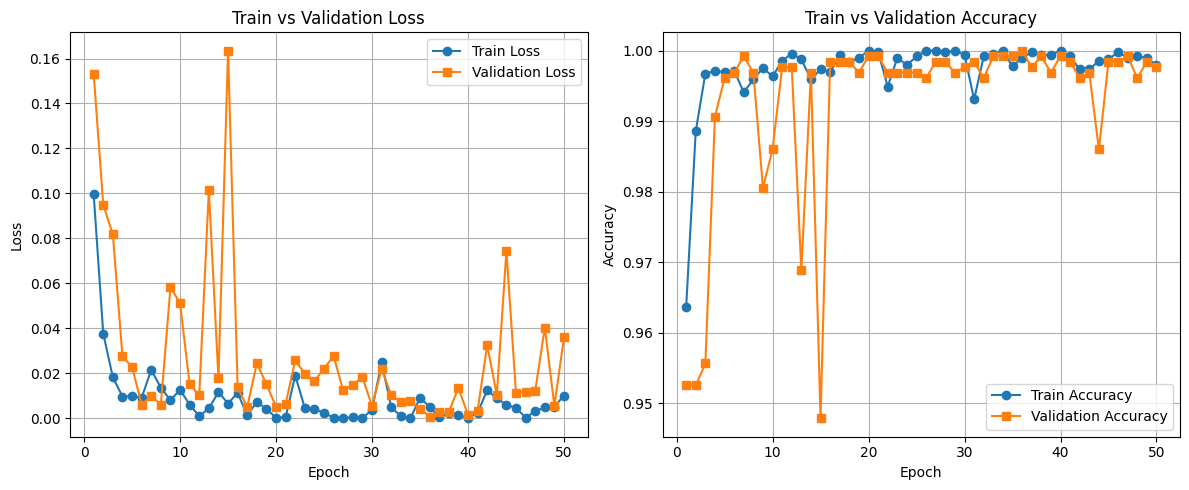

In [58]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


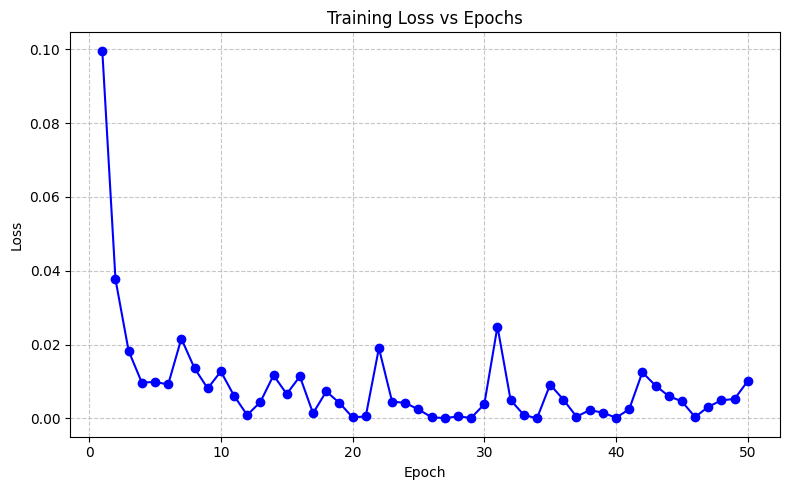

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='blue')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



📊 Final Evaluation:
Accuracy : 0.9977
Precision: 0.9972
Recall   : 0.9986
F1 Score : 0.9979

Confusion matrix:
 [[570   2]
 [  1 712]]


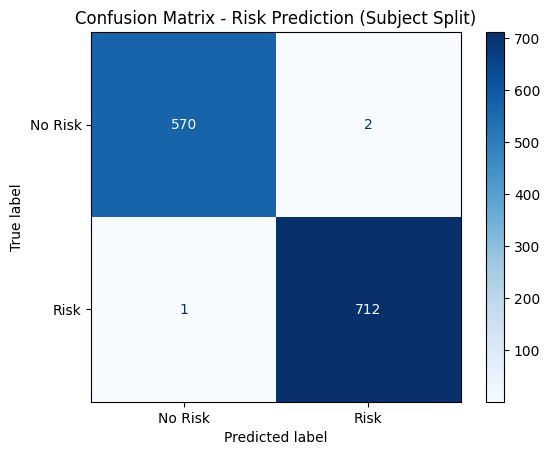

In [60]:

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        pred_labels = torch.argmax(preds, dim=1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(pred_labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n📊 Final Evaluation:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Risk", "Risk"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Risk Prediction (Subject Split)")
plt.show()

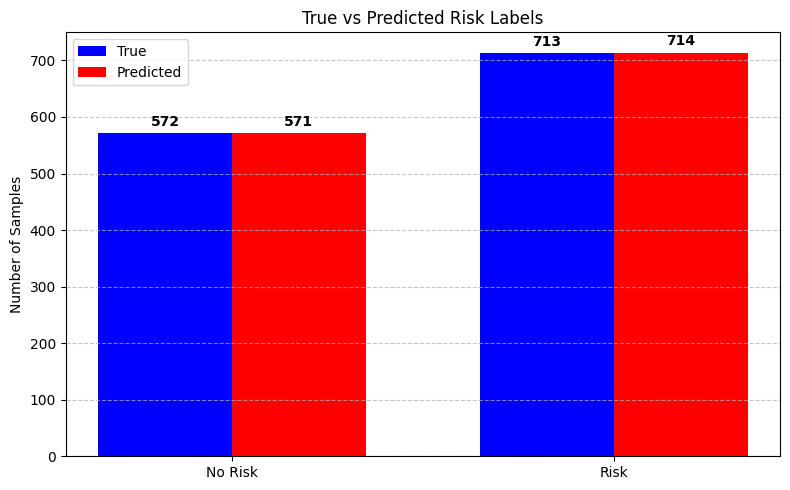

In [62]:
# Plot Bar Graph: True vs Predicted Labels
classes = ["No Risk", "Risk"]
true_counts = np.bincount(y_true)
pred_counts = np.bincount(y_pred)

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, true_counts, width, label='True', color='blue')
rects2 = ax.bar(x + width/2, pred_counts, width, label='Predicted', color='red')

ax.set_ylabel('Number of Samples')
ax.set_title('True vs Predicted Risk Labels')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
# Add counts on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

add_labels(rects1)
add_labels(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


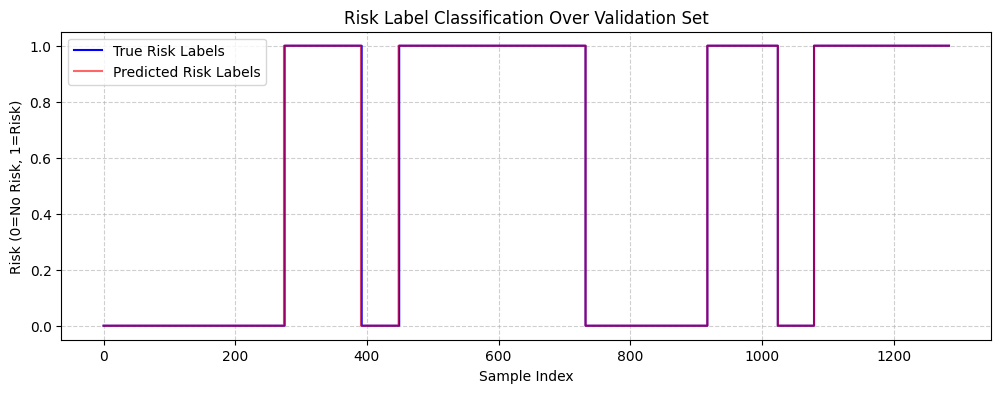

In [68]:
plt.figure(figsize=(12, 4))
plt.plot(y_true, label='True Risk Labels', drawstyle='steps-post', color='blue')
plt.plot(y_pred, label='Predicted Risk Labels', drawstyle='steps-post', color='red', alpha=0.6)
plt.title('Risk Label Classification Over Validation Set')
plt.xlabel('Sample Index')
plt.ylabel('Risk (0=No Risk, 1=Risk)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


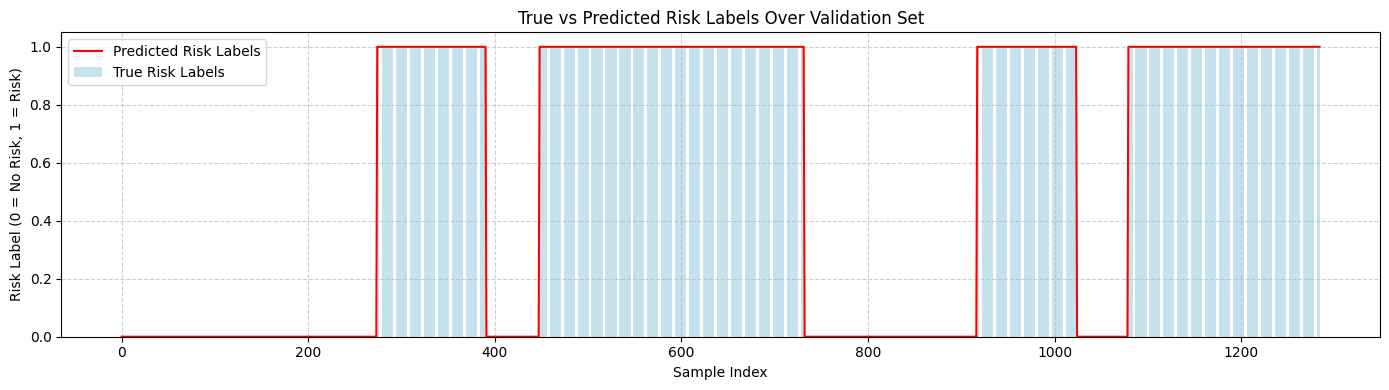

In [69]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 4))

# Bar chart for true labels
plt.bar(np.arange(len(y_true)), y_true, label='True Risk Labels', color='lightblue', alpha=0.7)

# Line plot for predicted labels
plt.plot(y_pred, label='Predicted Risk Labels', color='red', linewidth=1.5)

plt.title('True vs Predicted Risk Labels Over Validation Set')
plt.xlabel('Sample Index')
plt.ylabel('Risk Label (0 = No Risk, 1 = Risk)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
